In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from patsy import dmatrix, build_design_matrices
from scipy.stats import multivariate_normal
from itertools import cycle
import re
from scipy.linalg import pinv
from scipy.integrate import simpson

sns.set_theme()
sns.set_context("notebook")

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'Int64',
    'YearSeason': 'str',
    'LactationNumber': 'Int64',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'HeatLoad': 'float',
    'CumulativeHeatLoad': 'float',
}

milk_data = pd.read_csv('../Data/MergedData/HeatApproachYieldDataTest.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,HeatLoad,CumulativeHeatLoad
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8,3,2022-2,15.22,0.0000,...,0.000000,1.820438,0,0,0,0,9.912500,50.478673,-10.521327,0.0
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8,4,2022-2,18.96,15.2200,...,0.107655,1.589745,0,0,0,0,10.066667,53.841648,-7.158352,0.0
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8,5,2022-2,22.64,17.0900,...,0.089176,1.894598,0,1,0,0,10.466667,52.935959,-8.064041,0.0
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8,6,2022-2,26.49,18.9400,...,0.079936,2.877443,0,0,0,0,11.183333,52.872112,-8.127888,0.0
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8,7,2022-3,33.61,20.8275,...,0.098152,7.563598,0,1,0,0,12.704167,56.056547,-4.943453,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466533,2022-03-19,f454e660,SE-fcdf259d-0044-0,3709,41 Fjällko,9,274,2022-2,20.41,12.4860,...,0.020560,4.456951,0,0,0,0,3.866667,43.381437,-17.618563,0.0
466534,2022-03-20,f454e660,SE-fcdf259d-0044-0,3710,41 Fjällko,9,275,2022-2,12.17,12.8140,...,0.051173,0.523267,0,0,0,0,2.450000,40.920659,-20.079341,0.0
466535,2022-03-21,f454e660,SE-fcdf259d-0044-0,3711,41 Fjällko,9,276,2022-2,13.59,13.4100,...,0.051860,1.133275,0,0,0,0,3.170833,42.103862,-18.896137,0.0
466536,2022-03-22,f454e660,SE-fcdf259d-0044-0,3712,41 Fjällko,9,277,2022-2,13.20,14.0560,...,-0.062114,-1.031806,0,0,0,0,4.691667,43.334997,-17.665003,0.0


## Understanding Bayesian Linear Regression and GAMs

### 1. Generalized Additive Models (GAMs):

A Generalized Additive Model (GAM) is a flexible, non-parametric extension of linear models that allows the relationship between the predictors and the response variable to be modeled as a sum of smooth functions. Unlike a traditional linear model, which assumes a straight-line relationship between each predictor and the response, GAMs allow for nonlinear relationships.

The basic form of a GAM is:

$$
y = \beta_0 + f_1(x_1) + f_2(x_2) + \dots + f_p(x_p) + \epsilon
$$

Where:
- $y$ is the response variable.
- $f_i(x_i)$ are smooth functions of the predictors $x_i$.
- $\beta_0$ is the intercept.
- $\epsilon$ is the error term, assumed to be normally distributed with mean 0 and variance $\sigma^2$.

In the context of our implementation, these smooth functions $f_i(x_i)$ are represented by B-splines, which are piecewise polynomials defined over a series of intervals (knots).

### 2. Bayesian Linear Regression:

Bayesian linear regression involves incorporating prior beliefs about the parameters of the model and updating these beliefs in light of the observed data. The result is a posterior distribution over the parameters, which reflects both the prior information and the data.

The steps involved are:

1. **Specify the Prior Distribution:**
   - Before observing any data, we specify a prior distribution for the parameters of the model. For instance, if we have no strong prior beliefs, we might use a prior mean of zero and an identity covariance matrix.

2. **Likelihood of the Data:**
   - The likelihood function describes how likely the observed data is given a set of parameters. In linear regression, this is typically a Gaussian likelihood, assuming the errors are normally distributed.

3. **Posterior Distribution:**
   - Using Bayes' theorem, the posterior distribution is calculated by combining the prior distribution and the likelihood of the observed data. The posterior represents our updated beliefs about the parameters after seeing the data.

4. **Inference:**
   - We can draw samples from the posterior distribution to make predictions, quantify uncertainty, and understand the relationship between predictors and the response.

## Bayesian Generalized Additive Models (Bayesian GAMs)

In a Bayesian GAM, we apply the principles of Bayesian inference to the framework of a GAM. Here’s how it works, broken down by the blocks of code:

# Farm a624fb9a

### Block 1: Data Preparation and Visualization

**Mathematics Involved:**
- **Binning and Averaging**: The feature space (e.g., `CumulativeHeatLoad`) is divided into bins, and within each bin, the mean response (`NormalizedDailyYield`) is calculated. This step prepares the data for smoother modeling by summarizing it within localized regions.
- **Quantile Calculation**: Quantiles are calculated to determine the "knots" for the spline functions. The knots define the intervals over which the B-splines are piecewise polynomials.

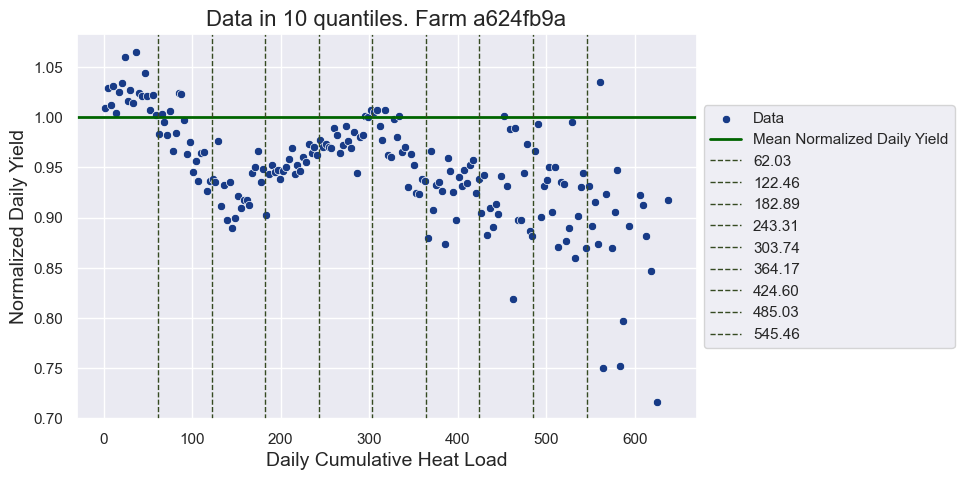

In [3]:
# Filter the data for farm 'a624fb9a'
farm_id = 'a624fb9a'
data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Set parameters
N = 200
input_feature_label = 'CumulativeHeatLoad'  # Adjust as needed

# Create bins and calculate midpoints
bins = pd.cut(data[input_feature_label], bins=N) 
bin_midpoints = bins.apply(lambda x: x.mid)
mean_yields = data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

# Assign target y and input vector x
x = mean_yields[input_feature_label].values
y = mean_yields.NormalizedDailyYield.values

# Calculate the mean of Normalized Daily Yield for this farm
mean_yield = data['NormalizedDailyYield'].mean()

# Divide the data into 'num_qs' number of quantiles
num_qs = 10
knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])
knot_group = np.digitize(x, knot_list)
knot_group = pd.Categorical(knot_group, ordered=True)

# Plot the data with quantiles
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
legend_texts = []
scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

# Add horizontal line for the mean yield
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

for knot in knot_list:
    line = ax.axvline(knot, color='#354A21', linestyle='--', linewidth=1, label=f"{knot:.2f}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"Data in {num_qs} quantiles. Farm {farm_id}", fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

## Block 1: Data Preparation and Visualization

### **Explanation:**
- **Data Filtering**: The first step is to filter `milk_data` for farm `a624fb9a`. This isolates data related only to that specific farm.
- **Feature and Binning**: The feature which we are interested in is selected as the input variable (`x`). The code then divides the data into 200 bins based on this feature. Binning means grouping continuous data into intervals.
- **Calculating Midpoints and Averages**: For each bin, the midpoint is computed (using `bins.apply(lambda x: x.mid)`), and the average `NormalizedDailyYield` is calculated within each bin. This step reduces the data noise by summarizing yield values within small temperature ranges.
- **Quantile Calculation**: The data is divided into `num_qs` quantiles (in this case, 10). Quantiles split the data into equal parts based on the distribution, creating "knots" that will be used in the spline functions.
- **Visualization**: The scatterplot shows the relationship between for example the feature `CumulativeHeatLoad` and `NormalizedDailyYield`, with vertical lines marking the quantile boundaries (knots). This visualization helps us understand how the data is distributed and where the key points (knots) are located.


### Block 2: B-Spline Basis Function Creation

**Mathematics Involved:**
- **B-Splines**: The smooth functions $f_i(x_i)$ in the GAM are approximated using B-splines. A B-spline basis function is a piecewise polynomial that is non-zero only over a certain range of the predictor variable. The B-spline basis functions are defined by the degree of the polynomial and the positions of the knots.
  
- **Design Matrix $B$**: The design matrix $B$ is constructed, where each column corresponds to a basis function. The value of $B_{ij}$ represents the contribution of the $j$ :th basis function to the $i$ :th observation.

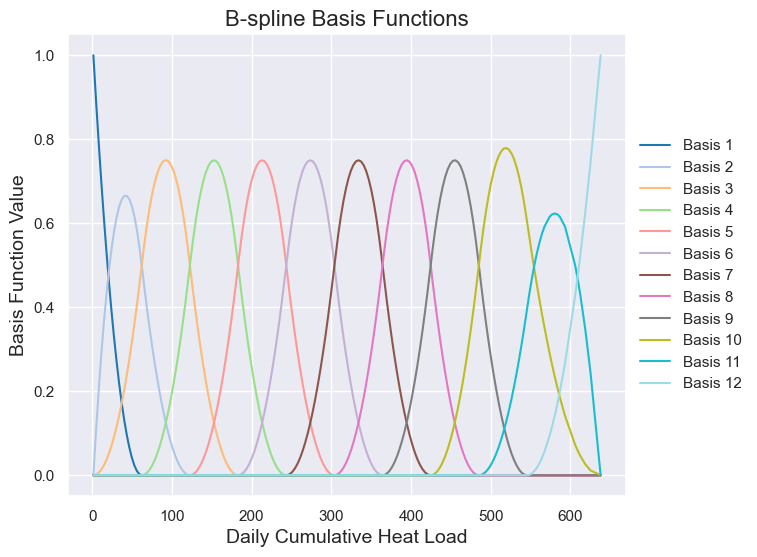

In [4]:
# Define the function for B-splines or other spline types
def Phi(a, knots, degree=3, spline_type='B'):
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B

# Create the design matrix for B-splines
degree_spline = 2  # Change the order of the polynomial here
B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

# Plot the basis functions
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
legend_texts = [] 
for i in range(B.shape[1]):
    c = colors[i]
    line, = ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

plt.title('B-spline Basis Functions', fontsize=16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Basis Function Value', fontsize=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.show()

## Block 2: B-Spline Basis Function Creation

### **Explanation:**
- **B-Spline Basis Function**: Splines are piecewise polynomial functions that are particularly useful in regression when the relationship between variables isn’t linear. A B-spline is a type of spline function defined over a series of intervals, or "knots."
- **`Phi` Function**: This function creates a design matrix `B` for different types of spline basis functions (`B`, `CR`, `CC`). The argument `degree` controls the polynomial degree (e.g., 2 for quadratic splines).
- **Creating the Design Matrix**: The design matrix `B` is created using the B-spline basis functions. This matrix will be used in the regression model to express the `x` values in terms of these splines.
- **Visualizing Basis Functions**: The code plots each of the basis functions over the input data range. These plots show how each basis function behaves and how they combine to fit the data. The sum of these weighted basis functions will approximate the target variable (`y`).


### Block 3: Bayesian Regression and Posterior Distribution

**Mathematics Involved:**
- **Prior Specification**: 
  - **Prior Mean ($m_0$)**: Initially, the prior mean for the coefficients is set based on a least-squares fit or some other estimate from the data.
  - **Prior Covariance ($S_0$)**: The covariance of the coefficients is estimated based on the data, reflecting our prior uncertainty about the coefficients.

- **Posterior Calculation**:
  - **Posterior Covariance ($S_N$)**: The posterior covariance matrix is calculated using the formula:
    $$
    S_N = \left(S_0^{-1} + \beta B^T B\right)^{-1}
    $$
    where $B$ is the design matrix and $\beta$ is the precision (inverse variance) of the observation noise.
  
  - **Posterior Mean ($m_N$)**: The posterior mean is updated using:
    $$
    m_N = S_N \left(S_0^{-1} m_0 + \beta B^T y\right)
    $$
    This mean reflects our updated belief about the coefficients after observing the data.

- **Regularization**: A small regularization term is added to the diagonal of $S_N$ to ensure it is positive semi-definite, making it suitable for sampling from a multivariate normal distribution.

Posterior of coefficients with updated priors. Farm a624fb9a
Mean squared error is... 0.0012


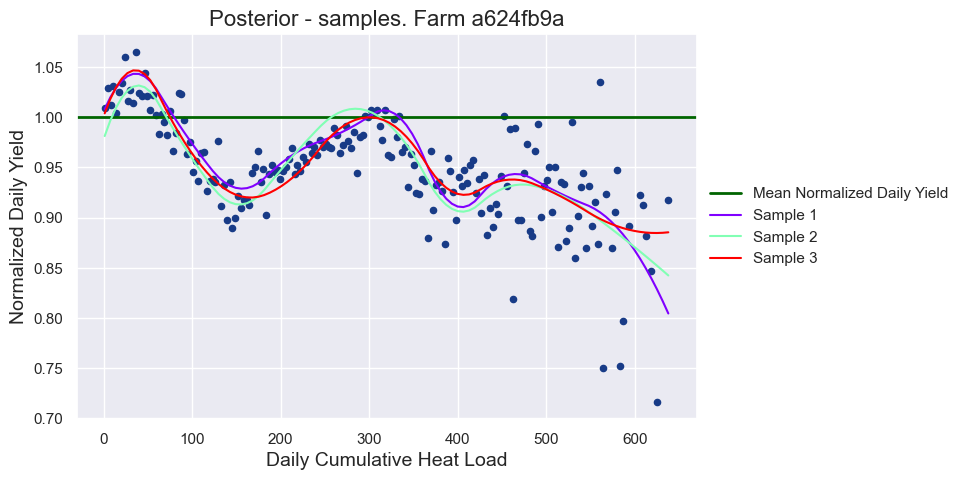

In [5]:
# Calculate empirical priors from the data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

beta = 1/np.var(y)

# Compute the posterior distribution with new priors
SN = pinv(pinv(S0) + beta * B.T @ B)

# Adding a small regularization term to ensure positive semi-definiteness
regularization_term = 1e-6 * np.eye(D)
SN += regularization_term

mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with updated priors. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN)**2)
print(f"{mse:.4f}")

# Visualize the posterior
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

n = 100  # number of grid-points
xs = np.linspace(x.min(), x.max(), n)
new_data = {'x': xs}

B_star = build_design_matrices([B.design_info], new_data)[0]
B_star = np.asarray(B_star)

# Compute corresponding values f(x*)
fs = B_star @ ws.T

# Plot the samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(ws.shape[0]):
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'Posterior - samples. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

## Block 3: Bayesian Regression and Posterior Distribution

### **Explanation:**
- **Prior Distribution**: In Bayesian statistics, we begin with a "prior" belief about the parameters before observing the data. Instead of the default priors, we now use the mean of the observed data or coefficients from a simple linear regression as the prior mean (`m0`), and the covariance of the observed data as the prior covariance (`S0`).
- **Noise Precision (`beta`)**: The term `beta` is the inverse of the variance of the observations (`y`). It measures the precision (certainty) of the observed data.
- **Pseudoinverse (`pinv`)**: The pseudoinverse helps to deal with cases where the matrix `S0` (and hence `SN`) may be near-singular, providing a more stable inversion. This ensures that the posterior calculation is robust, even when the design matrix `B` has multicollinearity.
- **Regularization**: A small regularization term is added to the diagonal of the covariance matrix `SN` to ensure it is positive semi-definite, which is necessary for drawing samples from a multivariate normal distribution.
- **Posterior Distribution**: After observing the data, the "posterior" distribution is updated using Bayes' theorem. `SN` is the updated covariance matrix, and `mN` is the updated mean. These capture our updated belief about the weights of the basis functions given the observed data.
- **Sampling from the Posterior**: To visualize the uncertainty in the model, we sample several sets of weights (`ws`) from the posterior distribution and use these to compute different possible functions (`fs`) that fit the data.
- **Visualization**: The plotted samples show different possible fits to the data, reflecting the uncertainty in the model. Each line represents a different possible set of coefficients sampled from the posterior.


### Block 4: Basis Function Contributions

**Mathematics Involved:**
- **Weighted Basis Functions**: Each basis function is multiplied by its corresponding posterior weight ($w_i$) to form the contribution of that basis function to the overall model. The final model is the sum of these contributions:
  $$
  \mathbf{B} \mathbf{w}^T = \sum_{i} w_i b_i(x)
  $$
  
- **Model Interpretation**: By plotting each weighted basis function, we can visually assess how each part of the input space contributes to the overall model. This provides insights into the non-linear relationships captured by the model.

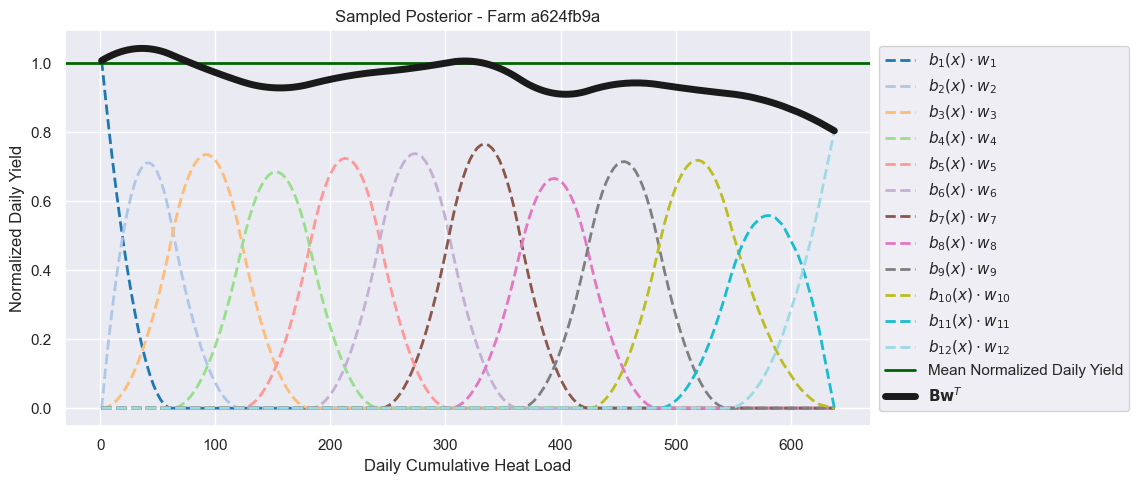

In [6]:
# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
BB = B

for i in range(B.shape[1]):
    c = colors[i]
    label = f'$b_{{{i+1}}}(x) \\cdot w_{{{i+1}}}$'
    ax.plot(x, ws[0][i] * B[:, i], linestyle='--', c=c, label=label, linewidth=2)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

label_sum = '$\\mathbf{B} \\mathbf{w}^T$'
ax.plot(x, np.dot(ws[0], BB.T), color='k', linewidth=5, label=label_sum)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title(f'Sampled Posterior - Farm {farm_id}')
ax.set_xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel

plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.gcf().set_edgecolor('none')

plt.show()

## Block 4: Basis Function Contributions

### **Explanation:**
- **Contribution of Each Basis Function**: This block visualizes how each basis function contributes to the final model. Each basis function (`b_i(x)`) is multiplied by its corresponding weight (`w_i`), resulting in a component of the model's output.
- **Plotting Individual Contributions**: Each dashed line represents the contribution of one basis function to the overall fit. The solid black line is the sum of these contributions, which should approximate the observed data (`y`).
- **Understanding Model Structure**: This visualization helps in understanding how the final model is constructed from its components. Each basis function has a local effect around its knot, and the sum of all these effects gives the overall curve.


### Block 5: Predictive Distribution and Uncertainty

**Mathematics Involved:**
- **Predictive Mean ($\mu_*$)**: For a new input $x_*$, the predictive mean is calculated using:
  $$
  \mu_* = B_* m_N
  $$
  where $B_*$ is the design matrix for the new input.

- **Predictive Variance ($\sigma^2_*$)**: The predictive variance includes both the model uncertainty (due to the posterior covariance $S_N$) and the observation noise:
  $$
  \sigma^2_* = B_* S_N B_*^T + \frac{1}{\beta} I
  $$

- **Uncertainty Visualization**: The predictive mean and intervals (1σ, 2σ, 3σ) are plotted to show the uncertainty around the predictions. This highlights regions where the model is more or less certain about its predictions.

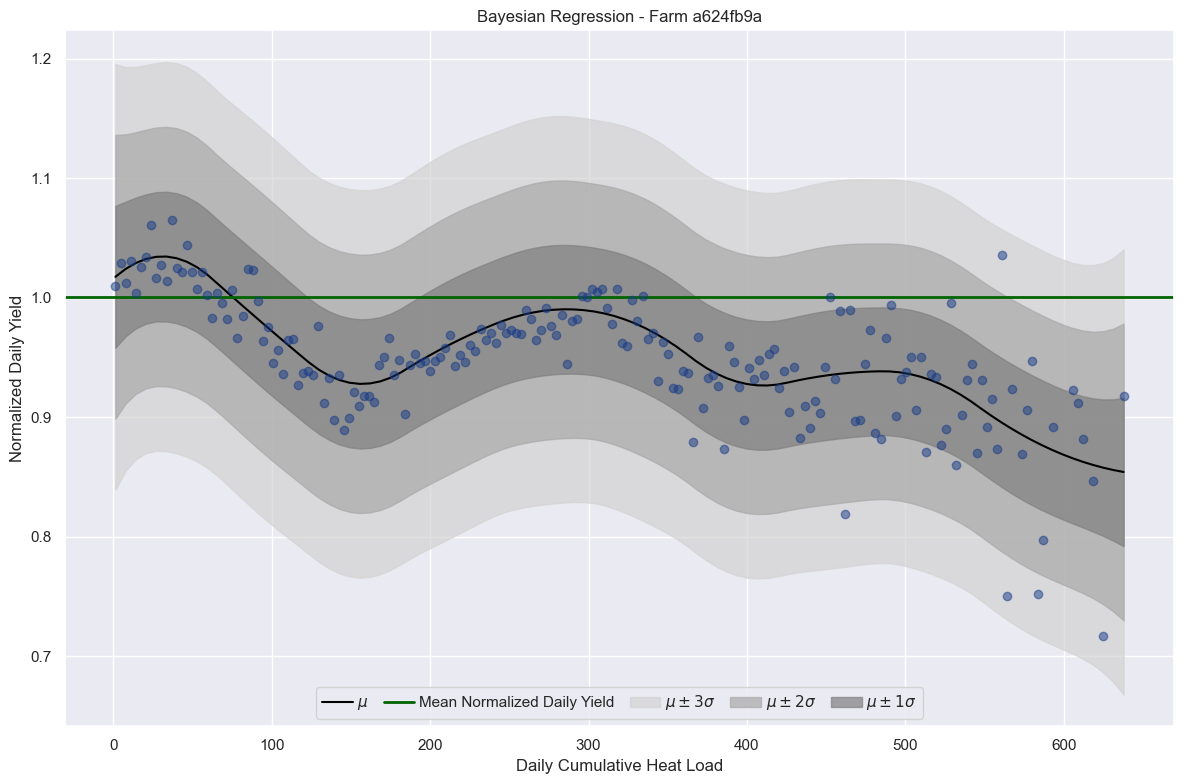

In [7]:
mstar = B_star @ mN
Sstar = B_star @ SN @ B_star.T + beta**(-1) * np.eye(n)

# Extract standard deviation of predictive distribution
stdpred = np.sqrt(np.diag(Sstar))

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar, 'black', label = f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

line = plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
line = plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
line = plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, columnspacing=1, handletextpad=0.3)
plt.title(f'Bayesian Regression - Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()

## Block 5: Predictive Distribution and Uncertainty

### **Explanation:**
- **Predictive Mean and Variance**: `mstar` represents the predictive mean for each value of `xs` (a grid of `x` values). `Sstar` is the predictive variance, which includes the uncertainty from both the model (due to posterior variance) and the observation noise (beta term).
- **Uncertainty Visualization**: The plot shows the predictive mean (`mstar`) as a black line. The shaded areas represent the uncertainty around this mean at different confidence levels (1σ, 2σ, 3σ). The wider the shaded area, the greater the uncertainty in the prediction.
- **Understanding Model Confidence**: This visualization is crucial for understanding how confident the model is in its predictions. If the shaded areas are narrow, the model is more confident; if they are wide, there's more uncertainty.
- **Updated Posterior Parameters**: Since `mN` and `SN` have been updated with the new priors and regularization, the predictive distribution here reflects those changes, making the model more stable and potentially more accurate.

### Block 6: Maximum Likelihood Estimation (MLE) and Model Refit

**Mathematics Involved:**
- **Residuals and MLE for $\beta$**: The residuals (differences between observed and predicted values) are used to re-estimate $\beta$ using Maximum Likelihood Estimation (MLE). This provides a more data-driven estimate of the observation noise precision.

- **Updated Posterior with MLE**:
  - **Posterior Covariance and Mean**: With the new $\beta_{MLE}$, the posterior covariance $S_{N_{MLE}}$ and mean $m_{N_{MLE}}$ are recalculated. This updates the model to reflect the more accurate noise precision.
  
  - **Revised Predictions**: The model is refit using the updated posterior, and the predictive distribution is recalculated to reflect the changes. This may improve the model's accuracy and provide more realistic uncertainty estimates.

Posterior of coefficients with MLE and ridge regularization. Farm a624fb9a
Mean squared error is... 0.0011


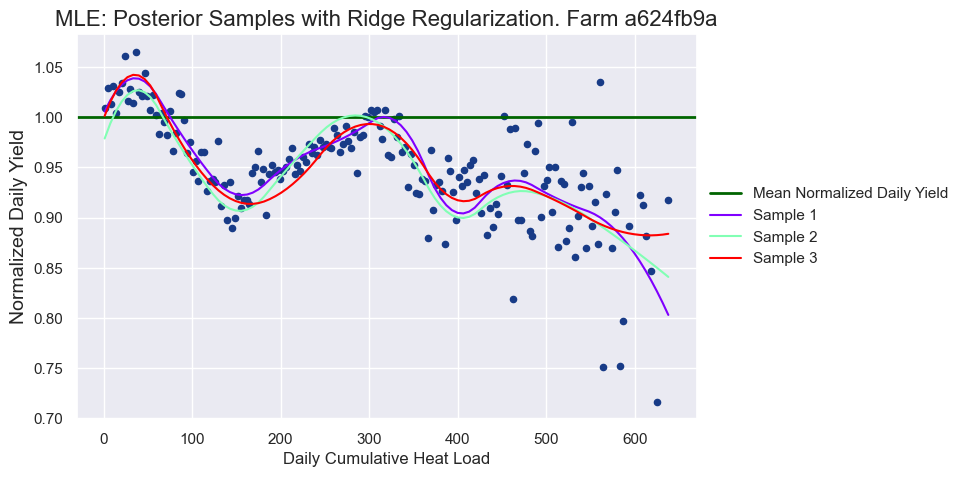

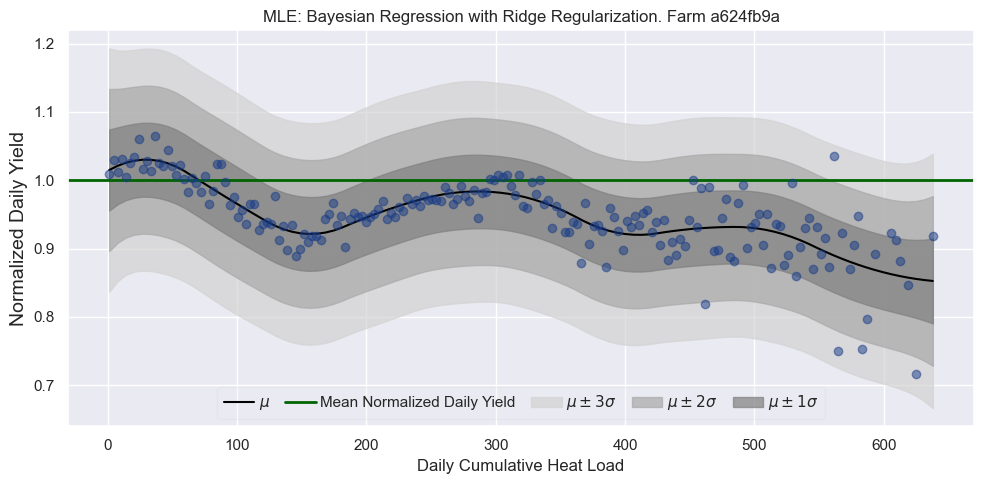

In [8]:
# Step 1: Calculate empirical priors from the correct data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

# Estimate beta (precision of noise)
beta = 1 / np.var(y)

# Define the regularization parameter (lambda)
lambda_ridge = 0.01  # Adjust this to control the strength of regularization

# Step 2: Apply MLE with Ridge Regularization
SN = pinv(pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(D))
mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with MLE and ridge regularization. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN) ** 2)
print(f"{mse:.4f}")

# Step 3: Visualize Posterior Samples

# Sample from the posterior distribution
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

# Generate predictions for the sampled posteriors
fs = B_star @ ws.T

# Plot the posterior samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

# Plot the sampled posteriors
color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(samples):  # Loop over the number of samples
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i + 1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'MLE: Posterior Samples with Ridge Regularization. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.show()

# Step 4: Visualize the MLE Bayesian Regression with Uncertainty

mstar_mle = B_star @ mN
Sstar_mle = B_star @ SN @ B_star.T + beta ** (-1) * np.eye(B_star.shape[0])

stdpred_mle = np.sqrt(np.diag(Sstar_mle))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar_mle, 'black', label=f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

plt.fill_between(xs, mstar_mle + 3 * stdpred_mle, mstar_mle - 3 * stdpred_mle, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
plt.fill_between(xs, mstar_mle + 2 * stdpred_mle, mstar_mle - 2 * stdpred_mle, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
plt.fill_between(xs, mstar_mle + 1 * stdpred_mle, mstar_mle - 1 * stdpred_mle, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, framealpha=0.2, columnspacing=1, handletextpad=0.3)

plt.title(f'MLE: Bayesian Regression with Ridge Regularization. Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()

## Block 6: Maximum Likelihood Estimation (MLE) and Model Refit

### **Explanation:**
- **MLE for Beta**: Here, `beta` is re-estimated using Maximum Likelihood Estimation (MLE) based on the residuals (differences between observed and predicted values). MLE provides a more data-driven estimate of `beta`, potentially improving the model fit.
- **Updated Posterior**: With the new `beta_mle`, the posterior distribution is recalculated (`SN_mle` and `mN_mle`). This gives a potentially more accurate model because `beta` now better reflects the variability in the data.
- **Visualizing MLE Results**: The samples from the updated posterior (`ws_mle`) are plotted similarly to the previous posterior, showing possible fits. Additionally, the predictive distribution with uncertainty is visualized again, but now with the MLE estimate.
- **Model Improvement Check**: The MSE (Mean Squared Error) is recalculated and printed, allowing you to compare it to the original model to see if MLE improved the fit.
- **Regularization and Stability**: As in Block 3, the regularization ensures that the covariance matrix remains positive semi-definite, allowing for stable sampling from the posterior.


## Summary

In this Bayesian Generalized Additive Model (GAM), we combine the flexibility of GAMs with the probabilistic approach of Bayesian inference. By using B-splines as the smooth functions, we allow for complex, nonlinear relationships between the predictors and the response variable.

The Bayesian approach not only provides a point estimate of the model parameters but also quantifies the uncertainty around these estimates, making it possible to assess the confidence of predictions. By updating the priors with empirical data and applying techniques like MLE, the model is further refined to better capture the underlying patterns in the data. 

This framework is particularly powerful in situations where the relationships between variables are not well understood or are expected to be nonlinear, as it allows for a data-driven, flexible modeling approach while incorporating prior knowledge and quantifying uncertainty.

In [9]:
# Define the mean yield level for reference
mean_yield = data['NormalizedDailyYield'].mean()

# Calculate areas above and below the mean yield
above_mean = np.maximum(mstar_mle - mean_yield, 0)
below_mean = np.maximum(mean_yield - mstar_mle, 0)

# Integrate to find the area above and below the mean yield
area_above_mean = simpson(above_mean, x=xs)  # Use keyword argument 'x'
area_below_mean = simpson(below_mean, x=xs)  # Use keyword argument 'x'

# Calculate the net area (above - below)
net_area = area_above_mean - area_below_mean

# Normalize by the total range of cumulative heat load
range_cum_heatload = xs[-1] - xs[0]
net_effect_per_unit = net_area / range_cum_heatload

# Express the net effect as a percentage of the mean yield
net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

print(f"The net effect of increasing cumulative heat load on yield is {net_effect_percentage:.2f}%.")

The net effect of increasing cumulative heat load on yield is -5.62%.


In [10]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'FarmCumHeatLoadMilkProduction'])

# Create a new DataFrame for the current farm's result
new_result = pd.DataFrame([{
    'FarmName_Pseudo': farm_id,
    'FarmCumHeatLoadMilkProduction [%]': net_effect_percentage
}])

# Check if results_df is empty before concatenation
if results_df.empty:
    results_df = new_result
else:
    results_df = pd.concat([results_df, new_result], ignore_index=True)

results_df

,FarmName_Pseudo,FarmCumHeatLoadMilkProduction [%]
0,a624fb9a,-5.620818


# Farm 5c06d92d

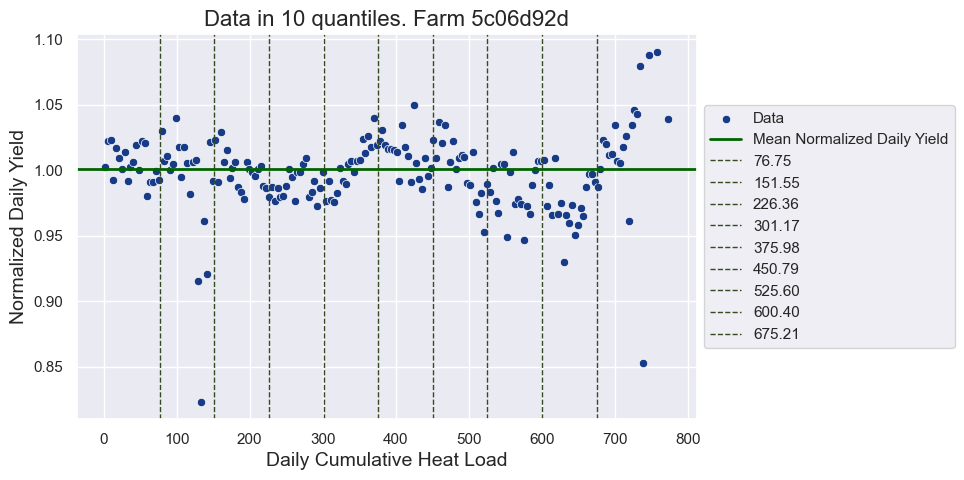

In [11]:
# Filter the data for farm 'a624fb9a'
farm_id = '5c06d92d'
data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Set parameters
N = 200
input_feature_label = 'CumulativeHeatLoad'  # Adjust as needed

# Create bins and calculate midpoints
bins = pd.cut(data[input_feature_label], bins=N) 
bin_midpoints = bins.apply(lambda x: x.mid)
mean_yields = data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

# Assign target y and input vector x
x = mean_yields[input_feature_label].values
y = mean_yields.NormalizedDailyYield.values

# Calculate the mean of Normalized Daily Yield for this farm
mean_yield = data['NormalizedDailyYield'].mean()

# Divide the data into 'num_qs' number of quantiles
num_qs = 10
knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])
knot_group = np.digitize(x, knot_list)
knot_group = pd.Categorical(knot_group, ordered=True)

# Plot the data with quantiles
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
legend_texts = []
scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

# Add horizontal line for the mean yield
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

for knot in knot_list:
    line = ax.axvline(knot, color='#354A21', linestyle='--', linewidth=1, label=f"{knot:.2f}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"Data in {num_qs} quantiles. Farm {farm_id}", fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

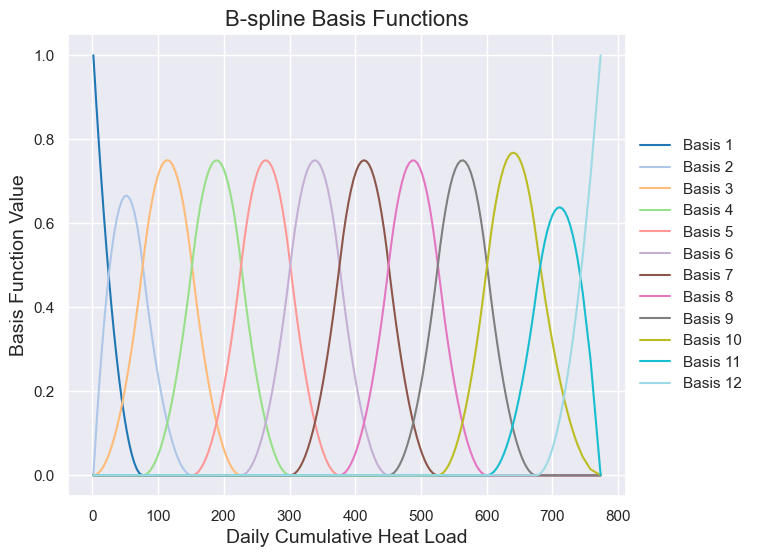

In [12]:
# Define the function for B-splines or other spline types
def Phi(a, knots, degree=3, spline_type='B'):
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B

# Create the design matrix for B-splines
degree_spline = 2  # Change the order of the polynomial here
B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

# Plot the basis functions
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
legend_texts = [] 
for i in range(B.shape[1]):
    c = colors[i]
    line, = ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

plt.title('B-spline Basis Functions', fontsize=16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Basis Function Value', fontsize=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.show()

Posterior of coefficients with updated priors. Farm 5c06d92d
Mean squared error is... 0.0011


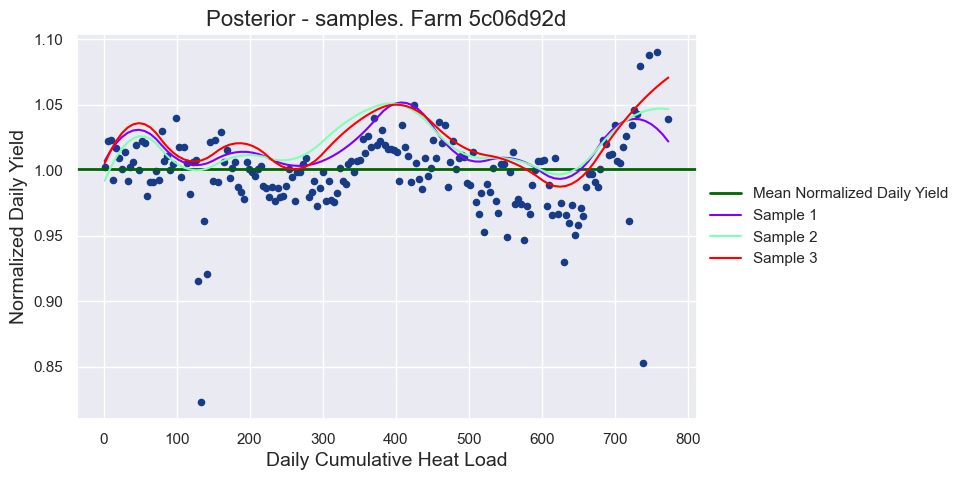

In [13]:
# Calculate empirical priors from the data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

beta = 1/np.var(y)

# Compute the posterior distribution with new priors
SN = pinv(pinv(S0) + beta * B.T @ B)

# Adding a small regularization term to ensure positive semi-definiteness
regularization_term = 1e-6 * np.eye(D)
SN += regularization_term

mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with updated priors. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN)**2)
print(f"{mse:.4f}")

# Visualize the posterior
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

n = 100  # number of grid-points
xs = np.linspace(x.min(), x.max(), n)
new_data = {'x': xs}

B_star = build_design_matrices([B.design_info], new_data)[0]
B_star = np.asarray(B_star)

# Compute corresponding values f(x*)
fs = B_star @ ws.T

# Plot the samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(ws.shape[0]):
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'Posterior - samples. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

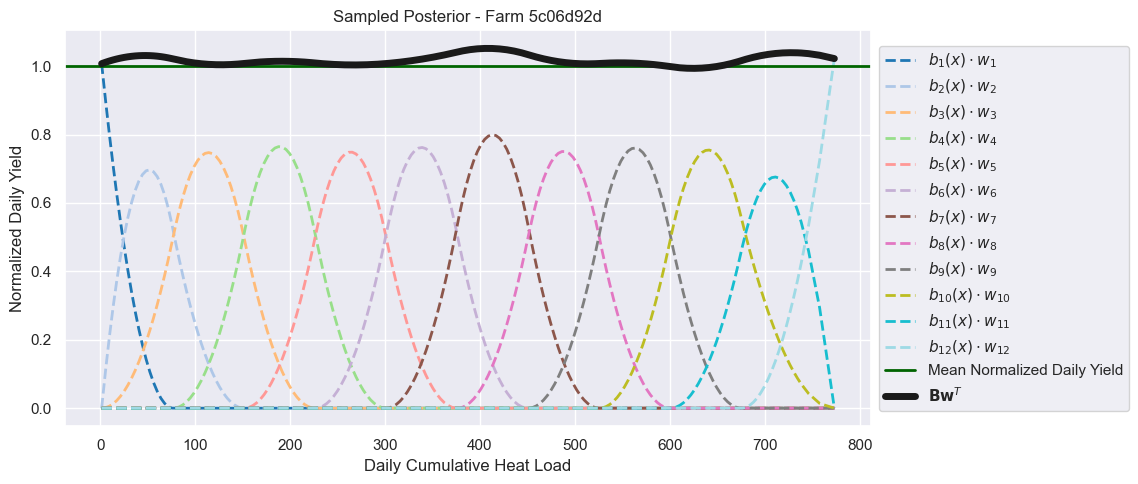

In [14]:
# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
BB = B

for i in range(B.shape[1]):
    c = colors[i]
    label = f'$b_{{{i+1}}}(x) \\cdot w_{{{i+1}}}$'
    ax.plot(x, ws[0][i] * B[:, i], linestyle='--', c=c, label=label, linewidth=2)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

label_sum = '$\\mathbf{B} \\mathbf{w}^T$'
ax.plot(x, np.dot(ws[0], BB.T), color='k', linewidth=5, label=label_sum)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title(f'Sampled Posterior - Farm {farm_id}')
ax.set_xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel

plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.gcf().set_edgecolor('none')

plt.show()

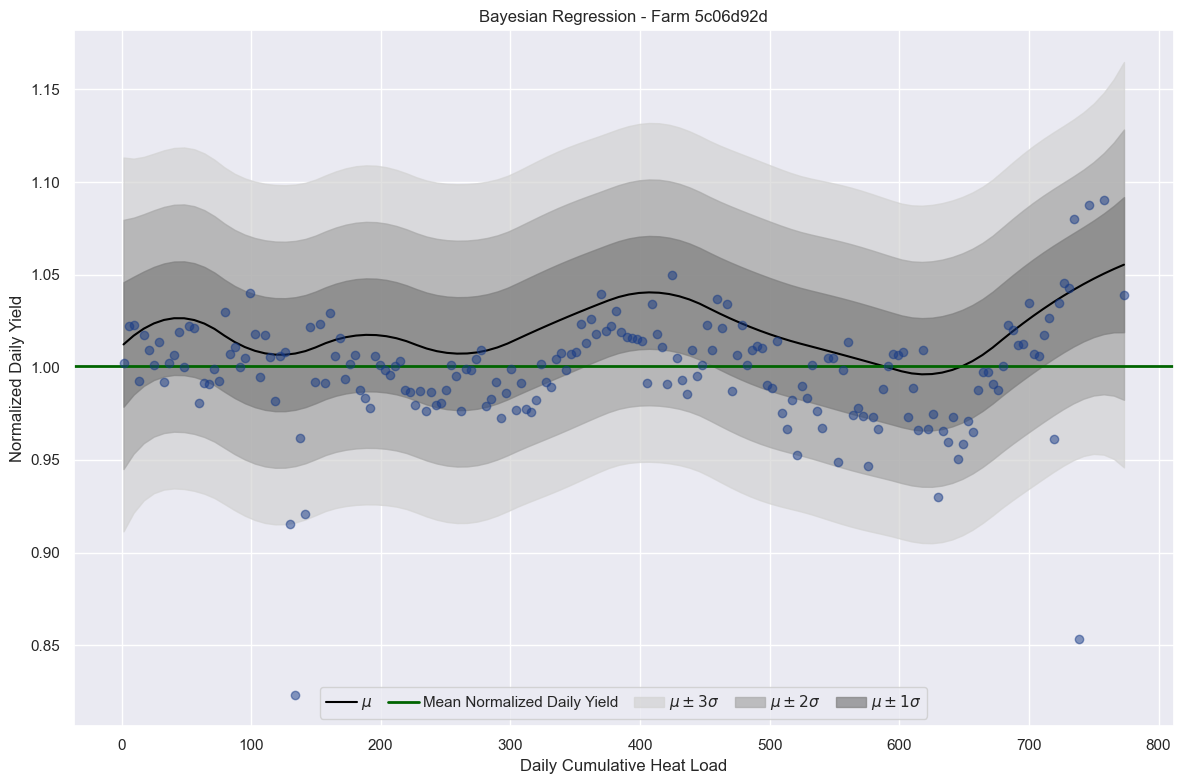

In [15]:
mstar = B_star @ mN
Sstar = B_star @ SN @ B_star.T + beta**(-1) * np.eye(n)

# Extract standard deviation of predictive distribution
stdpred = np.sqrt(np.diag(Sstar))

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar, 'black', label = f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

line = plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
line = plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
line = plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, columnspacing=1, handletextpad=0.3)
plt.title(f'Bayesian Regression - Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()

Posterior of coefficients with MLE and ridge regularization. Farm 5c06d92d
Mean squared error is... 0.0007


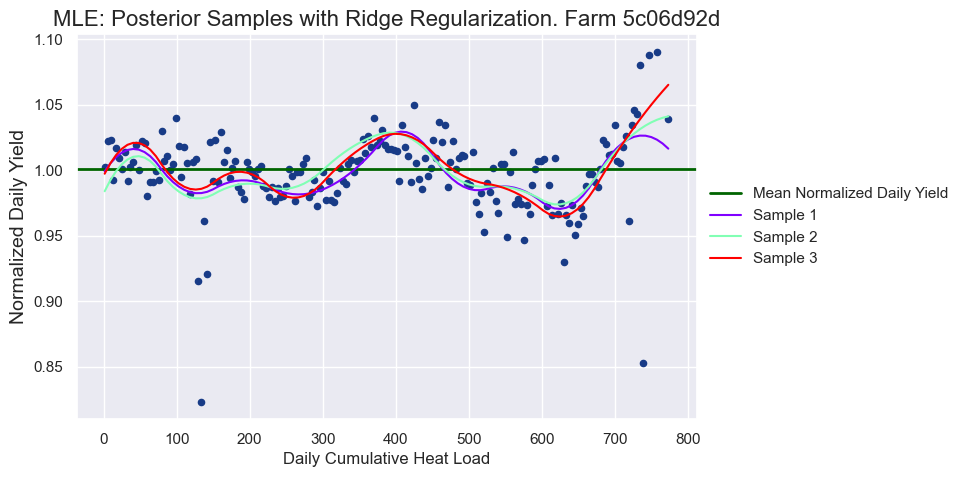

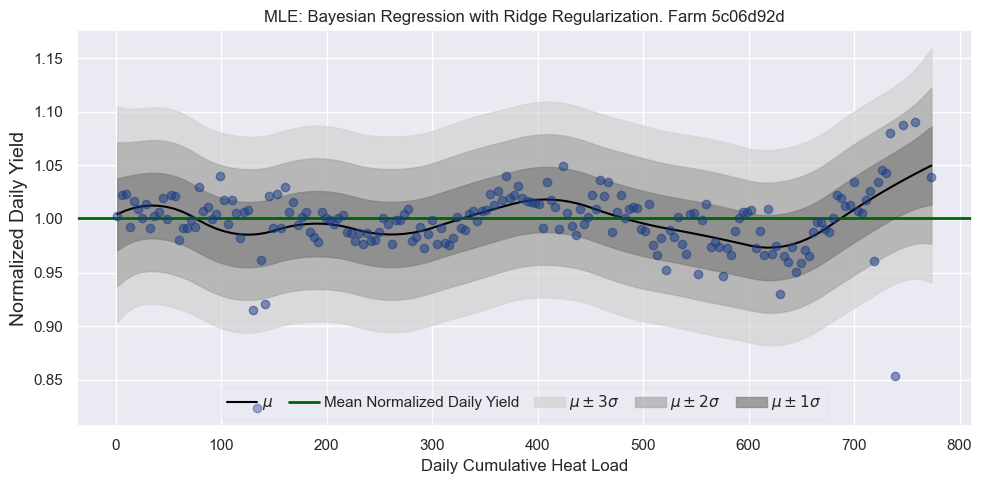

In [16]:
# Step 1: Calculate empirical priors from the correct data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

# Estimate beta (precision of noise)
beta = 1 / np.var(y)

# Define the regularization parameter (lambda)
lambda_ridge = 0.01  # Adjust this to control the strength of regularization

# Step 2: Apply MLE with Ridge Regularization
SN = pinv(pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(D))
mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with MLE and ridge regularization. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN) ** 2)
print(f"{mse:.4f}")

# Step 3: Visualize Posterior Samples

# Sample from the posterior distribution
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

# Generate predictions for the sampled posteriors
fs = B_star @ ws.T

# Plot the posterior samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

# Plot the sampled posteriors
color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(samples):  # Loop over the number of samples
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i + 1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'MLE: Posterior Samples with Ridge Regularization. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.show()

# Step 4: Visualize the MLE Bayesian Regression with Uncertainty

mstar_mle = B_star @ mN
Sstar_mle = B_star @ SN @ B_star.T + beta ** (-1) * np.eye(B_star.shape[0])

stdpred_mle = np.sqrt(np.diag(Sstar_mle))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar_mle, 'black', label=f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

plt.fill_between(xs, mstar_mle + 3 * stdpred_mle, mstar_mle - 3 * stdpred_mle, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
plt.fill_between(xs, mstar_mle + 2 * stdpred_mle, mstar_mle - 2 * stdpred_mle, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
plt.fill_between(xs, mstar_mle + 1 * stdpred_mle, mstar_mle - 1 * stdpred_mle, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, framealpha=0.2, columnspacing=1, handletextpad=0.3)

plt.title(f'MLE: Bayesian Regression with Ridge Regularization. Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Define the mean yield level for reference
mean_yield = data['NormalizedDailyYield'].mean()

# Calculate areas above and below the mean yield
above_mean = np.maximum(mstar_mle - mean_yield, 0)
below_mean = np.maximum(mean_yield - mstar_mle, 0)

# Integrate to find the area above and below the mean yield
area_above_mean = simpson(above_mean, x=xs)  # Use keyword argument 'x'
area_below_mean = simpson(below_mean, x=xs)  # Use keyword argument 'x'

# Calculate the net area (above - below)
net_area = area_above_mean - area_below_mean

# Normalize by the total range of cumulative heat load
range_cum_heatload = xs[-1] - xs[0]
net_effect_per_unit = net_area / range_cum_heatload

# Express the net effect as a percentage of the mean yield
net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

print(f"The net effect of increasing cumulative heat load on yield is {net_effect_percentage:.2f}%.")

The net effect of increasing cumulative heat load on yield is -0.20%.


In [18]:
# Create a new DataFrame for the current farm's result
new_result = pd.DataFrame([{
    'FarmName_Pseudo': farm_id,
    'FarmCumHeatLoadMilkProduction [%]': net_effect_percentage
}])

results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df

,FarmName_Pseudo,FarmCumHeatLoadMilkProduction [%]
0,a624fb9a,-5.620818
1,5c06d92d,-0.195714


## Farm 752efd72

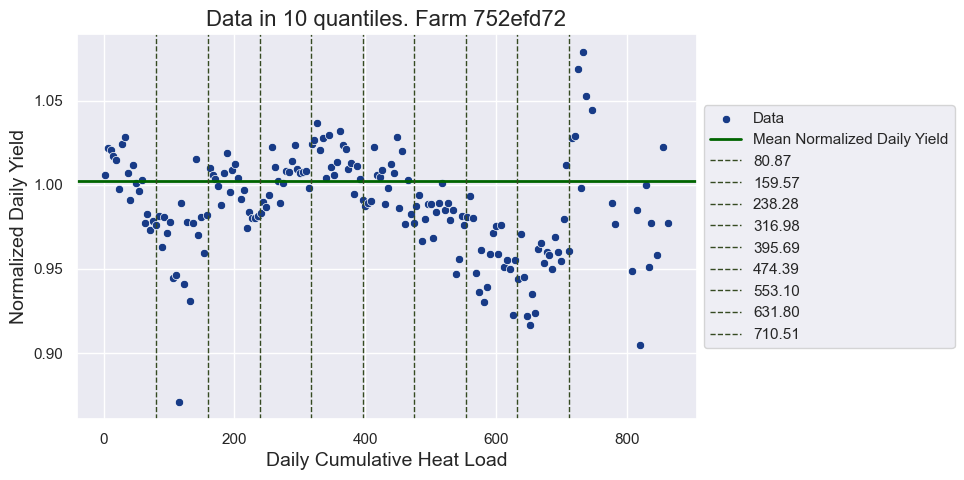

In [19]:
# Filter the data for farm 'a624fb9a'
farm_id = '752efd72'
data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Set parameters
N = 200
input_feature_label = 'CumulativeHeatLoad'  # Adjust as needed

# Create bins and calculate midpoints
bins = pd.cut(data[input_feature_label], bins=N) 
bin_midpoints = bins.apply(lambda x: x.mid)
mean_yields = data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

# Assign target y and input vector x
x = mean_yields[input_feature_label].values
y = mean_yields.NormalizedDailyYield.values

# Calculate the mean of Normalized Daily Yield for this farm
mean_yield = data['NormalizedDailyYield'].mean()

# Divide the data into 'num_qs' number of quantiles
num_qs = 10
knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])
knot_group = np.digitize(x, knot_list)
knot_group = pd.Categorical(knot_group, ordered=True)

# Plot the data with quantiles
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
legend_texts = []
scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

# Add horizontal line for the mean yield
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

for knot in knot_list:
    line = ax.axvline(knot, color='#354A21', linestyle='--', linewidth=1, label=f"{knot:.2f}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"Data in {num_qs} quantiles. Farm {farm_id}", fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

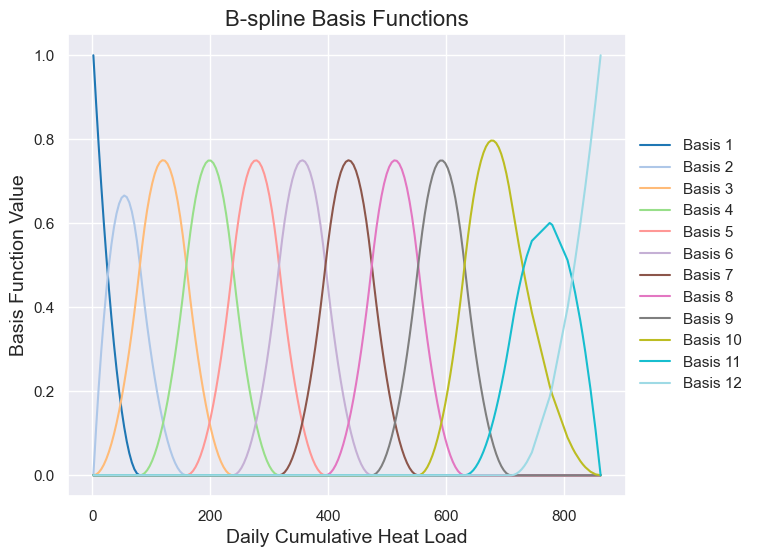

In [20]:
# Define the function for B-splines or other spline types
def Phi(a, knots, degree=3, spline_type='B'):
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B

# Create the design matrix for B-splines
degree_spline = 2  # Change the order of the polynomial here
B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

# Plot the basis functions
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
legend_texts = [] 
for i in range(B.shape[1]):
    c = colors[i]
    line, = ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

plt.title('B-spline Basis Functions', fontsize=16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Basis Function Value', fontsize=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.show()

Posterior of coefficients with updated priors. Farm 752efd72
Mean squared error is... 0.0008


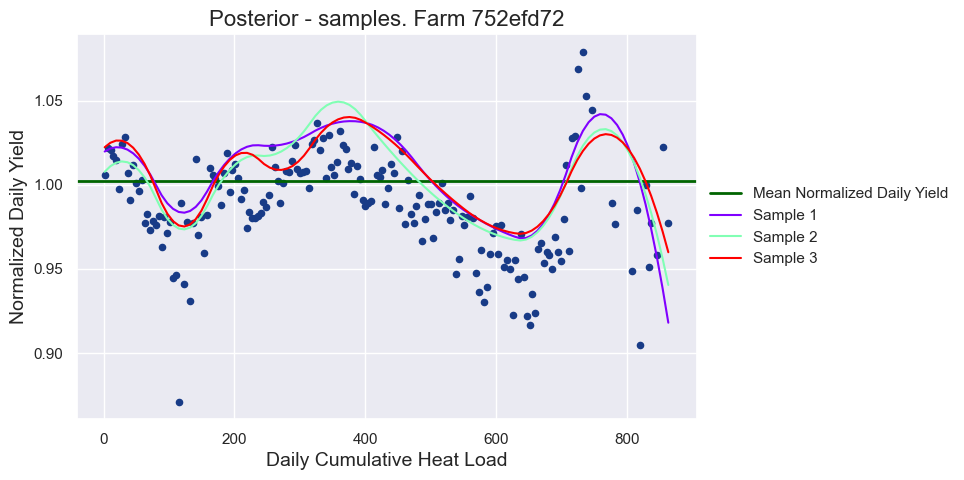

In [21]:
# Calculate empirical priors from the data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

beta = 1/np.var(y)

# Compute the posterior distribution with new priors
SN = pinv(pinv(S0) + beta * B.T @ B)

# Adding a small regularization term to ensure positive semi-definiteness
regularization_term = 1e-6 * np.eye(D)
SN += regularization_term

mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with updated priors. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN)**2)
print(f"{mse:.4f}")

# Visualize the posterior
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

n = 100  # number of grid-points
xs = np.linspace(x.min(), x.max(), n)
new_data = {'x': xs}

B_star = build_design_matrices([B.design_info], new_data)[0]
B_star = np.asarray(B_star)

# Compute corresponding values f(x*)
fs = B_star @ ws.T

# Plot the samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(ws.shape[0]):
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'Posterior - samples. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

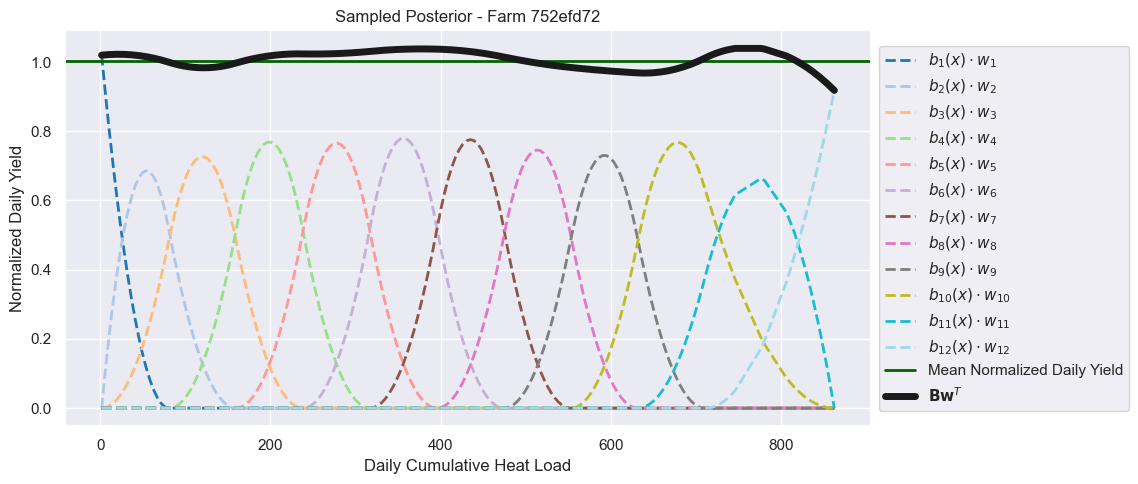

In [22]:
# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
BB = B

for i in range(B.shape[1]):
    c = colors[i]
    label = f'$b_{{{i+1}}}(x) \\cdot w_{{{i+1}}}$'
    ax.plot(x, ws[0][i] * B[:, i], linestyle='--', c=c, label=label, linewidth=2)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

label_sum = '$\\mathbf{B} \\mathbf{w}^T$'
ax.plot(x, np.dot(ws[0], BB.T), color='k', linewidth=5, label=label_sum)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title(f'Sampled Posterior - Farm {farm_id}')
ax.set_xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel

plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.gcf().set_edgecolor('none')

plt.show()

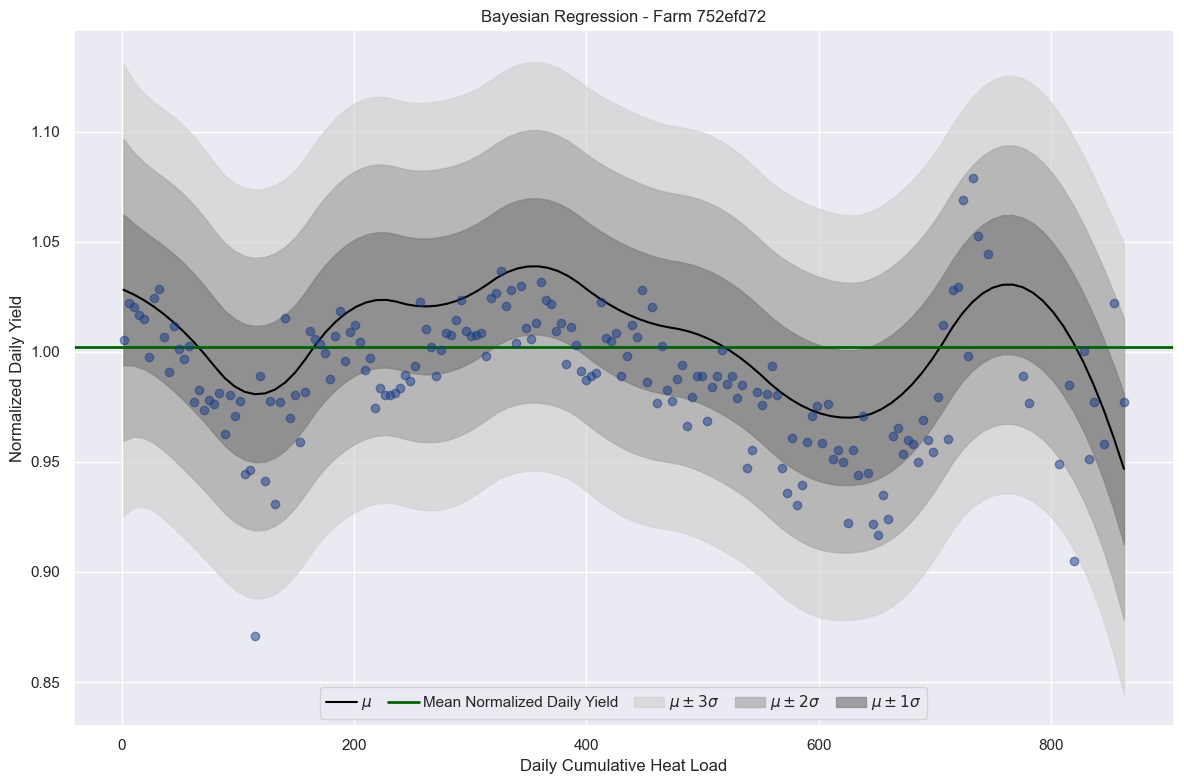

In [23]:
mstar = B_star @ mN
Sstar = B_star @ SN @ B_star.T + beta**(-1) * np.eye(n)

# Extract standard deviation of predictive distribution
stdpred = np.sqrt(np.diag(Sstar))

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar, 'black', label = f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

line = plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
line = plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
line = plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, columnspacing=1, handletextpad=0.3)
plt.title(f'Bayesian Regression - Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()

Posterior of coefficients with MLE and ridge regularization. Farm 752efd72
Mean squared error is... 0.0004


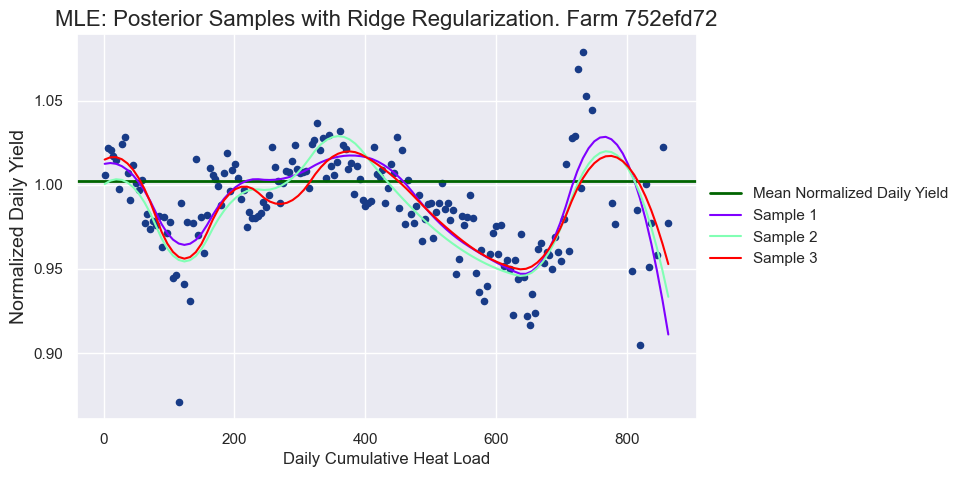

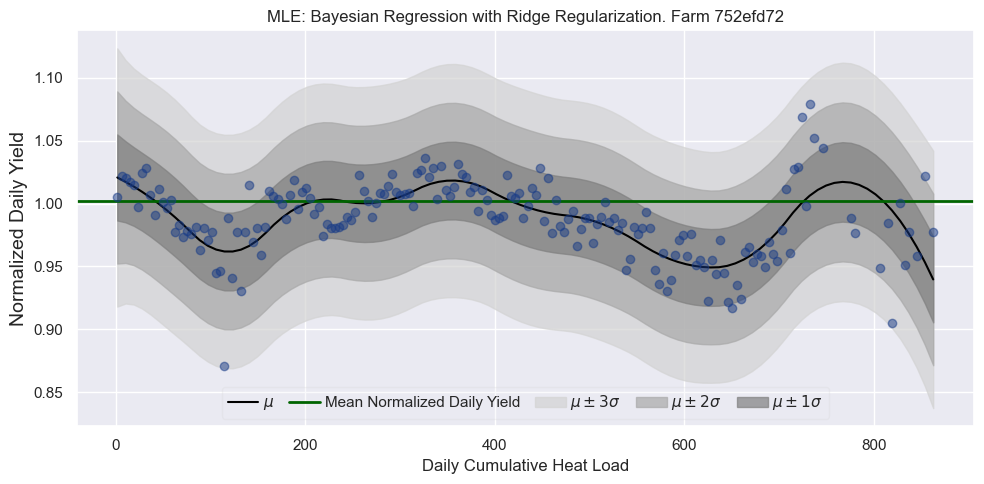

In [24]:
# Step 1: Calculate empirical priors from the correct data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

# Estimate beta (precision of noise)
beta = 1 / np.var(y)

# Define the regularization parameter (lambda)
lambda_ridge = 0.1  # Adjust this to control the strength of regularization

# Step 2: Apply MLE with Ridge Regularization
SN = pinv(pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(D))
mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with MLE and ridge regularization. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN) ** 2)
print(f"{mse:.4f}")

# Step 3: Visualize Posterior Samples

# Sample from the posterior distribution
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

# Generate predictions for the sampled posteriors
fs = B_star @ ws.T

# Plot the posterior samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

# Plot the sampled posteriors
color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(samples):  # Loop over the number of samples
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i + 1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'MLE: Posterior Samples with Ridge Regularization. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.show()

# Step 4: Visualize the MLE Bayesian Regression with Uncertainty

mstar_mle = B_star @ mN
Sstar_mle = B_star @ SN @ B_star.T + beta ** (-1) * np.eye(B_star.shape[0])

stdpred_mle = np.sqrt(np.diag(Sstar_mle))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar_mle, 'black', label=f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

plt.fill_between(xs, mstar_mle + 3 * stdpred_mle, mstar_mle - 3 * stdpred_mle, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
plt.fill_between(xs, mstar_mle + 2 * stdpred_mle, mstar_mle - 2 * stdpred_mle, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
plt.fill_between(xs, mstar_mle + 1 * stdpred_mle, mstar_mle - 1 * stdpred_mle, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, framealpha=0.2, columnspacing=1, handletextpad=0.3)

plt.title(f'MLE: Bayesian Regression with Ridge Regularization. Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Define the mean yield level for reference
mean_yield = data['NormalizedDailyYield'].mean()

# Calculate areas above and below the mean yield
above_mean = np.maximum(mstar_mle - mean_yield, 0)
below_mean = np.maximum(mean_yield - mstar_mle, 0)

# Integrate to find the area above and below the mean yield
area_above_mean = simpson(above_mean, x=xs)  # Use keyword argument 'x'
area_below_mean = simpson(below_mean, x=xs)  # Use keyword argument 'x'

# Calculate the net area (above - below)
net_area = area_above_mean - area_below_mean

# Normalize by the total range of cumulative heat load
range_cum_heatload = xs[-1] - xs[0]
net_effect_per_unit = net_area / range_cum_heatload

# Express the net effect as a percentage of the mean yield
net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

print(f"The net effect of increasing cumulative heat load on yield is {net_effect_percentage:.2f}%.")

The net effect of increasing cumulative heat load on yield is -1.32%.


In [26]:
# Create a new DataFrame for the current farm's result
new_result = pd.DataFrame([{
    'FarmName_Pseudo': farm_id,
    'FarmCumHeatLoadMilkProduction [%]': net_effect_percentage
}])

results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df

,FarmName_Pseudo,FarmCumHeatLoadMilkProduction [%]
0,a624fb9a,-5.620818
1,5c06d92d,-0.195714
2,752efd72,-1.321766


## Farm f454e660

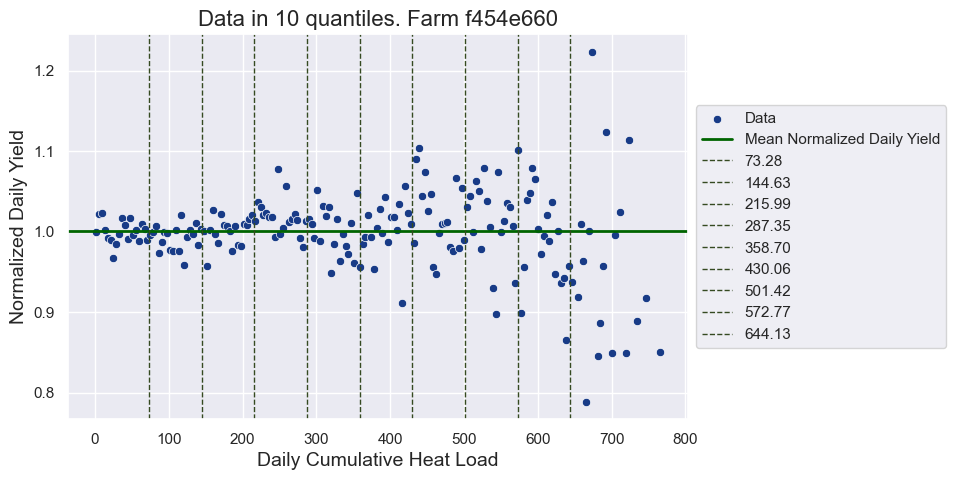

In [27]:
# Filter the data for farm 'a624fb9a'
farm_id = 'f454e660'
data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Set parameters
N = 200
input_feature_label = 'CumulativeHeatLoad'  # Adjust as needed

# Create bins and calculate midpoints
bins = pd.cut(data[input_feature_label], bins=N) 
bin_midpoints = bins.apply(lambda x: x.mid)
mean_yields = data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

# Assign target y and input vector x
x = mean_yields[input_feature_label].values
y = mean_yields.NormalizedDailyYield.values

# Calculate the mean of Normalized Daily Yield for this farm
mean_yield = data['NormalizedDailyYield'].mean()

# Divide the data into 'num_qs' number of quantiles
num_qs = 10
knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])
knot_group = np.digitize(x, knot_list)
knot_group = pd.Categorical(knot_group, ordered=True)

# Plot the data with quantiles
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
legend_texts = []
scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

# Add horizontal line for the mean yield
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

for knot in knot_list:
    line = ax.axvline(knot, color='#354A21', linestyle='--', linewidth=1, label=f"{knot:.2f}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"Data in {num_qs} quantiles. Farm {farm_id}", fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

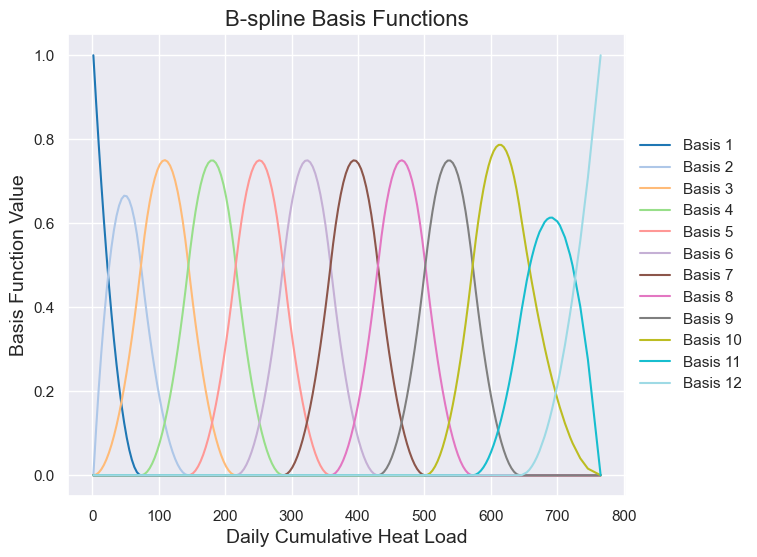

In [28]:
# Define the function for B-splines or other spline types
def Phi(a, knots, degree=3, spline_type='B'):
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B

# Create the design matrix for B-splines
degree_spline = 2  # Change the order of the polynomial here
B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

# Plot the basis functions
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
legend_texts = [] 
for i in range(B.shape[1]):
    c = colors[i]
    line, = ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

plt.title('B-spline Basis Functions', fontsize=16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Basis Function Value', fontsize=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.show()

Posterior of coefficients with updated priors. Farm f454e660
Mean squared error is... 0.0022


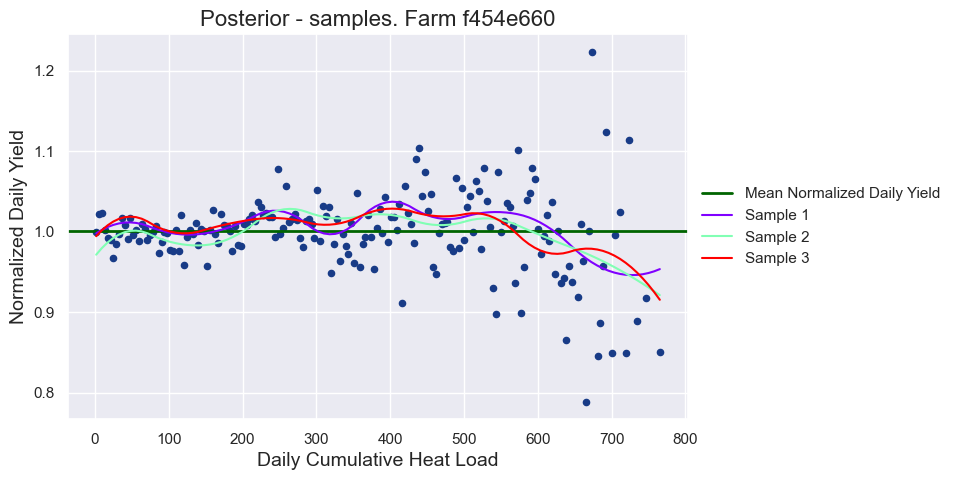

In [29]:
# Calculate empirical priors from the data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

beta = 1/np.var(y)

# Compute the posterior distribution with new priors
SN = pinv(pinv(S0) + beta * B.T @ B)

# Adding a small regularization term to ensure positive semi-definiteness
regularization_term = 1e-6 * np.eye(D)
SN += regularization_term

mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with updated priors. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN)**2)
print(f"{mse:.4f}")

# Visualize the posterior
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

n = 100  # number of grid-points
xs = np.linspace(x.min(), x.max(), n)
new_data = {'x': xs}

B_star = build_design_matrices([B.design_info], new_data)[0]
B_star = np.asarray(B_star)

# Compute corresponding values f(x*)
fs = B_star @ ws.T

# Plot the samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(ws.shape[0]):
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'Posterior - samples. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

plt.show()

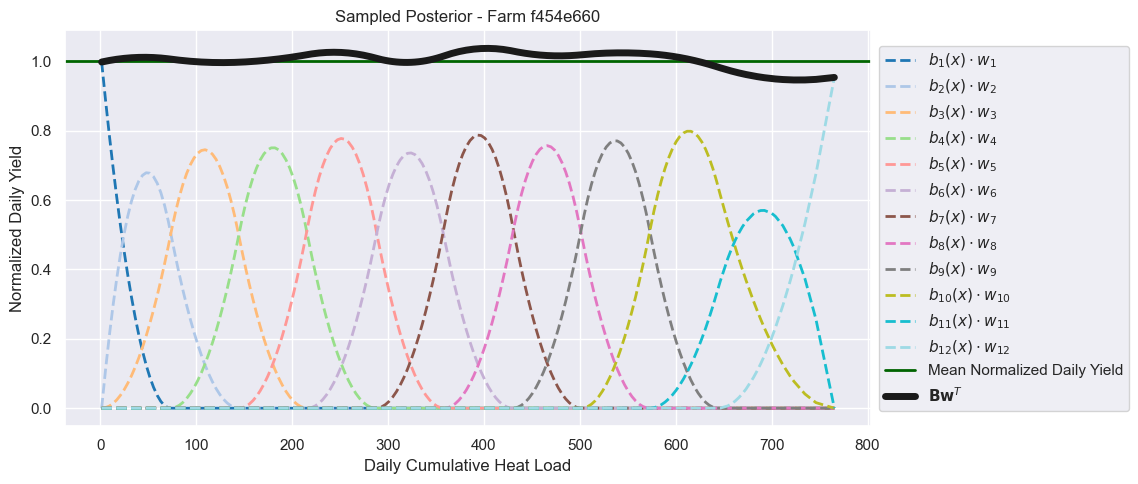

In [30]:
# Retrieve the 'tab20' colormap and generate the required number of distinct colors
color_map = plt.colormaps.get_cmap('tab20')
colors = color_map(np.linspace(0, 1, B.shape[1]))

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
BB = B

for i in range(B.shape[1]):
    c = colors[i]
    label = f'$b_{{{i+1}}}(x) \\cdot w_{{{i+1}}}$'
    ax.plot(x, ws[0][i] * B[:, i], linestyle='--', c=c, label=label, linewidth=2)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

label_sum = '$\\mathbf{B} \\mathbf{w}^T$'
ax.plot(x, np.dot(ws[0], BB.T), color='k', linewidth=5, label=label_sum)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title(f'Sampled Posterior - Farm {farm_id}')
ax.set_xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel

plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.gcf().set_edgecolor('none')

plt.show()

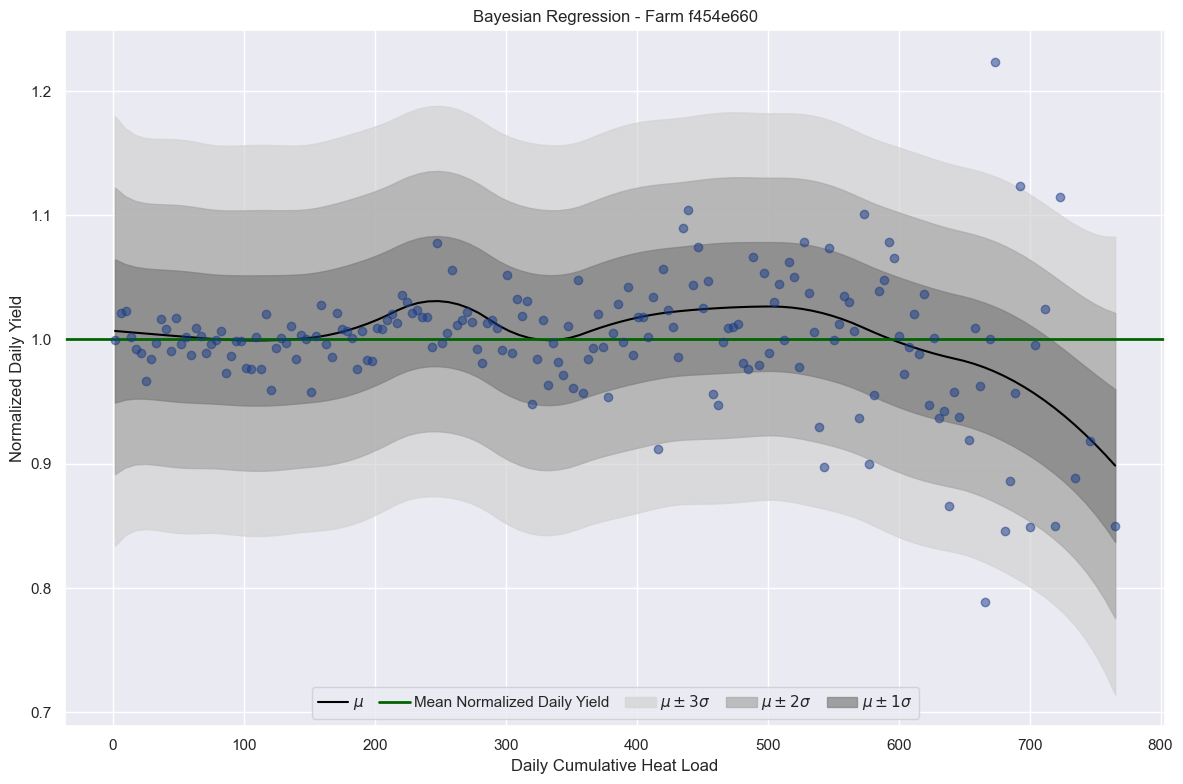

In [31]:
mstar = B_star @ mN
Sstar = B_star @ SN @ B_star.T + beta**(-1) * np.eye(n)

# Extract standard deviation of predictive distribution
stdpred = np.sqrt(np.diag(Sstar))

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar, 'black', label = f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

line = plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
line = plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
line = plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, columnspacing=1, handletextpad=0.3)
plt.title(f'Bayesian Regression - Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Normalized Daily Yield')  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()

Posterior of coefficients with MLE and ridge regularization. Farm f454e660
Mean squared error is... 0.0022


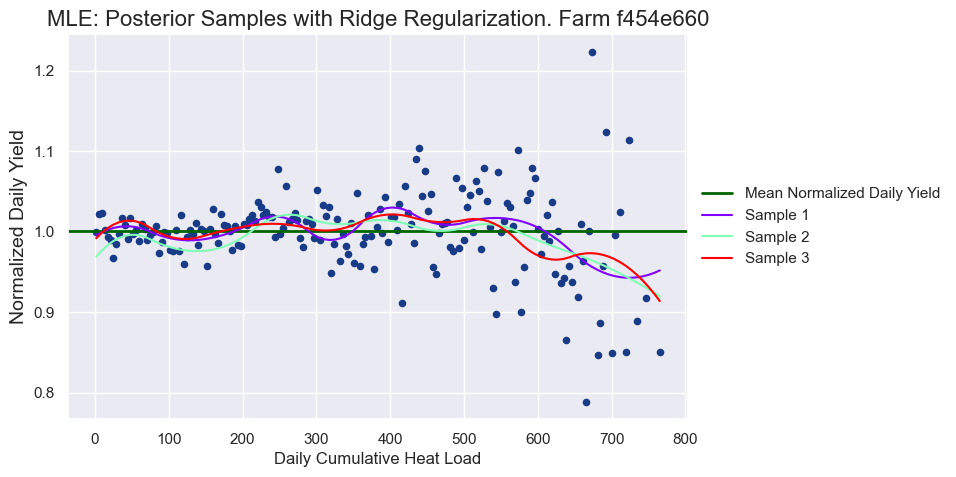

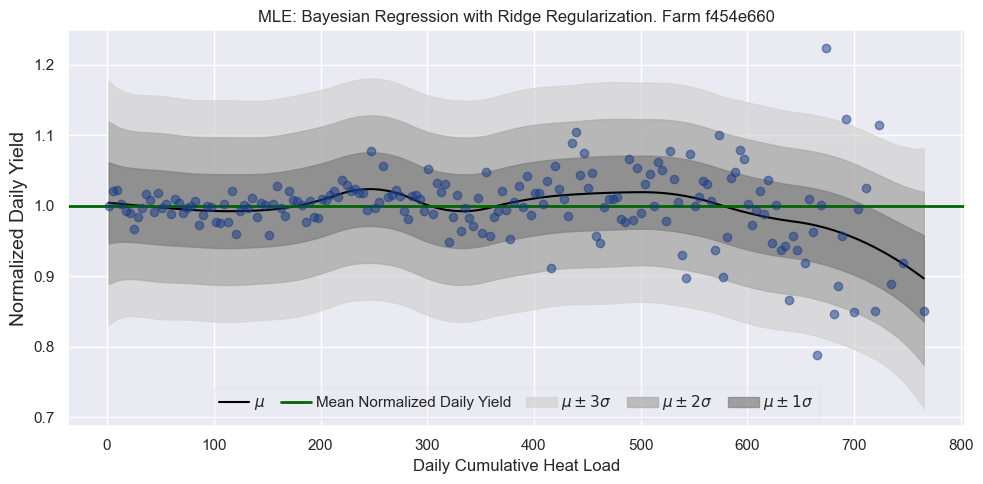

In [32]:
# Step 1: Calculate empirical priors from the correct data
D = B.shape[1]
m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

# Estimate beta (precision of noise)
beta = 1 / np.var(y)

# Define the regularization parameter (lambda)
lambda_ridge = 0.1  # Adjust this to control the strength of regularization

# Step 2: Apply MLE with Ridge Regularization
SN = pinv(pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(D))
mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficients with MLE and ridge regularization. Farm {farm_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN) ** 2)
print(f"{mse:.4f}")

# Step 3: Visualize Posterior Samples

# Sample from the posterior distribution
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

# Generate predictions for the sampled posteriors
fs = B_star @ ws.T

# Plot the posterior samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color='#183B87', zorder=1, s=20)

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

# Plot the sampled posteriors
color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(samples):  # Loop over the number of samples
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i + 1}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'MLE: Posterior Samples with Ridge Regularization. Farm {farm_id}', fontsize=16)
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.show()

# Step 4: Visualize the MLE Bayesian Regression with Uncertainty

mstar_mle = B_star @ mN
Sstar_mle = B_star @ SN @ B_star.T + beta ** (-1) * np.eye(B_star.shape[0])

stdpred_mle = np.sqrt(np.diag(Sstar_mle))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar_mle, 'black', label=f'$\mu$')  # predictive mean

# Add horizontal line for the mean yield
mean_yield = data['NormalizedDailyYield'].mean()
ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

plt.fill_between(xs, mstar_mle + 3 * stdpred_mle, mstar_mle - 3 * stdpred_mle, color='lightgray', alpha=0.7, label=f'$\mu \pm 3\\sigma$')
plt.fill_between(xs, mstar_mle + 2 * stdpred_mle, mstar_mle - 2 * stdpred_mle, color='darkgray', alpha=0.7, label=f'$\mu \pm 2\\sigma$')
plt.fill_between(xs, mstar_mle + 1 * stdpred_mle, mstar_mle - 1 * stdpred_mle, color='gray', alpha=0.7, label=f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, framealpha=0.2, columnspacing=1, handletextpad=0.3)

plt.title(f'MLE: Bayesian Regression with Ridge Regularization. Farm {farm_id}')
plt.xlabel('Daily ' + re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# Define the mean yield level for reference
mean_yield = data['NormalizedDailyYield'].mean()

# Calculate areas above and below the mean yield
above_mean = np.maximum(mstar_mle - mean_yield, 0)
below_mean = np.maximum(mean_yield - mstar_mle, 0)

# Integrate to find the area above and below the mean yield
area_above_mean = simpson(above_mean, x=xs)  # Use keyword argument 'x'
area_below_mean = simpson(below_mean, x=xs)  # Use keyword argument 'x'

# Calculate the net area (above - below)
net_area = area_above_mean - area_below_mean

# Normalize by the total range of cumulative heat load
range_cum_heatload = xs[-1] - xs[0]
net_effect_per_unit = net_area / range_cum_heatload

# Express the net effect as a percentage of the mean yield
net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

print(f"The net effect of increasing cumulative heat load on yield is {net_effect_percentage:.2f}%.")

The net effect of increasing cumulative heat load on yield is -0.52%.


In [34]:
# Create a new DataFrame for the current farm's result
new_result = pd.DataFrame([{
    'FarmName_Pseudo': farm_id,
    'FarmCumHeatLoadMilkProduction [%]': net_effect_percentage
}])

results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df

,FarmName_Pseudo,FarmCumHeatLoadMilkProduction [%]
0,a624fb9a,-5.620818
1,5c06d92d,-0.195714
2,752efd72,-1.321766
3,f454e660,-0.521014
